In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import pdb
from sklearn.linear_model import LogisticRegression
import time


# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

Raw training set shape: (15120, 56)
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
54
After split, Train and Dev dataset shapes are: (11340, 56) (37

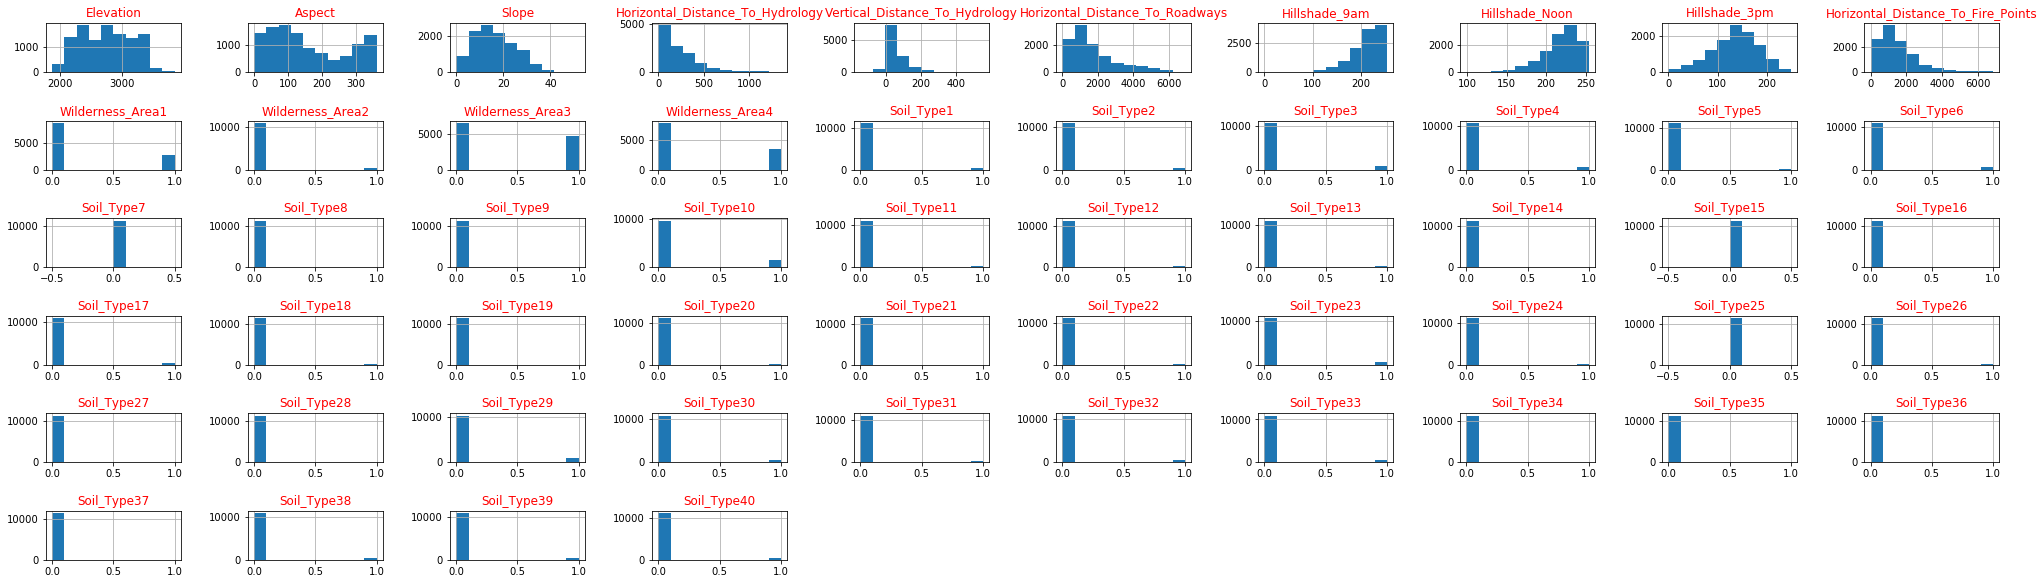

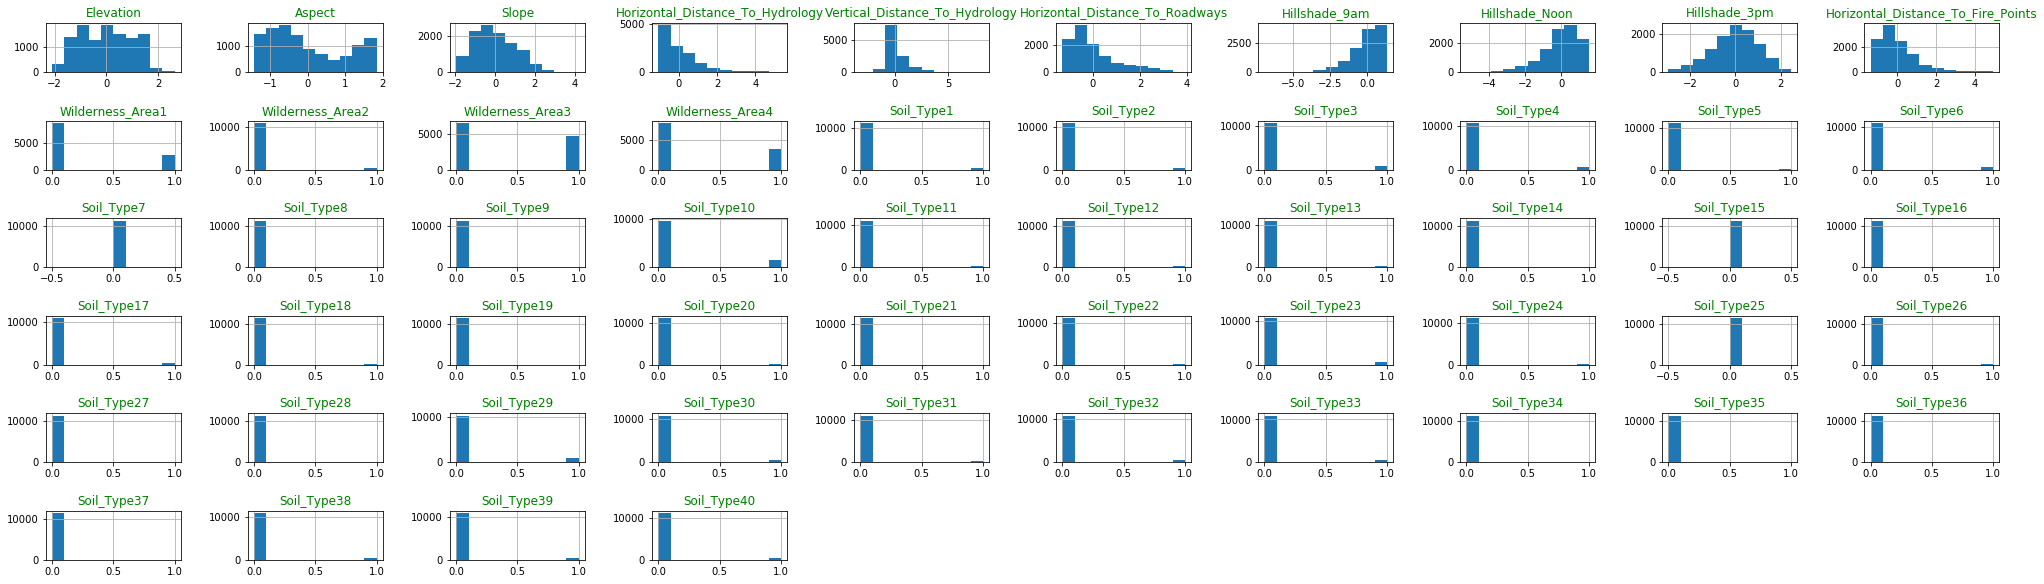

In [3]:
# import training data into frame. normalize, and split into train and dev. 

train_df = pd.read_csv('train.csv')

# check for missing values in frame. 
train_df.isnull().values.any()
print("Raw training set shape:",train_df.shape)

predictors = list(train_df) # includes ID and target/class columns
train_id = predictors.pop(0) # pop out ID column
target = list.pop(predictors) # pop out target column
print(predictors)
print(len(predictors))

# two kinds of normalization - min-max or z-score. z-score may lead to negative values for otherwise non-negative quantities 
# (such as altitude) - which may be ok from a prediction standpoint 

# should we be splitting after normalization. Or before? Before makes sense cause dev data should be a surrogate for actual - 
# - kaggle test data we have not seen yet. 
train_df, dev_df = train_test_split(train_df)

# display histograms for basic EDA. titles in Red. 
plt.figure(figsize=(35, 35))
plt.subplots_adjust(hspace=1.0,wspace=0.5)
for i in range(0,len(predictors)):
    plt.subplot(20,10,i+1)
    data = train_df[predictors[i]].T # transposing to view counts on y-axis
    ax = data.hist()
    ax.set_title(predictors[i],color='Red') 

# Needs to store these values for transforming new data presented to the eventual model for prediction. 
train_df_mean =  train_df.mean().astype(float)
train_df_sd = train_df.std().astype(float)
train_df_min = train_df.min().astype(float)
train_df_max = train_df.max().astype(float)

# going with z-scores. some columns may look weird. caveat emptor. note that dev-data is normalized based on train dist. 
train_df[predictors[0:10]] = (train_df[predictors[0:10]]-train_df_mean[predictors[0:10]])/train_df_sd[predictors[0:10]]
dev_df[predictors[0:10]] = (dev_df[predictors[0:10]]-train_df_mean[predictors[0:10]])/train_df_sd[predictors[0:10]]

print("After split, Train and Dev dataset shapes are:",train_df.shape, dev_df.shape)

# display histograms post normalization. Titles in Green.
plt.figure(figsize=(35, 35))
plt.subplots_adjust(hspace=1.0,wspace=0.5)
for i in range(0,len(predictors)):
    plt.subplot(20,10,i+1)
    data = train_df[predictors[i]].T # transposing to view counts on y-axis
    ax = data.hist()
    ax.set_title(predictors[i],color='Green') 

In [16]:
# Attempting to use a tree-based classifier as the base model. Evaluate Random Forest and Gradient Boosting. 
# But first, try a basic decision tree. 

dt = DecisionTreeClassifier()
parameter_grid = {'min_impurity_decrease': 3. ** np.arange(-10, 5)}
param_searcher = GridSearchCV(dt, parameter_grid, cv=10)
param_searcher.fit(train_df[predictors], train_df[target])
dt = DecisionTreeClassifier(**param_searcher.best_params_)
scores = cross_val_score(dt, train_df[predictors], train_df[target], cv=10)
print("best gridsearch score with vanilla decision tree and params:", param_searcher.best_score_,param_searcher.best_params_)
print("mean gridsearch score with vanilla decision tree:",scores.mean())

ValueError: Invalid parameter min_impurity_decrease for estimator DecisionTreeClassifier. Check the list of available parameters with `estimator.get_params().keys()`.

In [4]:
# Next, evaluate a Random Forest with 500 trees. 

rf = RandomForestClassifier(n_estimators=500, oob_score=True)
scores = cross_val_score(rf, train_df[predictors], train_df[target], cv=10)
print ("Mean R^2 = {:.3}".format(scores.mean()))

Mean R^2 = 0.856


In [5]:
# Evaluate Random Forest on dev data. 

rf.fit(train_df[predictors], train_df[target])
rf.score(dev_df[predictors], dev_df[target])

0.85449735449735453

In [ ]:
# Evaluate Gradient Boosting classifier with 500 estimators. 

gb = GradientBoostingClassifier(subsample=.7, n_estimators=500)
parameter_grid = {
    'max_depth': range(1, 6),
    'learning_rate': [.01, .05, .1],
    'max_features': [2, 5, 'auto']
}
param_searcher = GridSearchCV(gb, parameter_grid, cv=5)
param_searcher.fit(train_df[predictors], train_df[target])

# Evaluate GBC on dev data. 

gb = GradientBoostingRegressor(subsample=.7, n_estimators=500, **param_searcher.best_params_)
gb.fit(train_df[predictors], train_df[target])
gb.score(dev_df[predictors],dev_df[target])


It looks like a Random Forest with 500 estimators exhibiting 86% accuracy on dev data is a fairly good  initial choice for a base model to improve upon. Will revisit data normalization, consider demensionality reduction and other prediction models in cells below. 

Variance explained by first 1 principal components: 0.462
Variance explained by first 2 principal components: 0.619
Variance explained by first 3 principal components: 0.714
Variance explained by first 4 principal components: 0.766
Variance explained by first 5 principal components: 0.809
Variance explained by first 6 principal components: 0.847
Variance explained by first 7 principal components: 0.876
Variance explained by first 8 principal components: 0.898
Variance explained by first 9 principal components: 0.92
Variance explained by first 10 principal components: 0.93
Variance explained by first 11 principal components: 0.938
Variance explained by first 12 principal components: 0.943
Variance explained by first 13 principal components: 0.948
Variance explained by first 14 principal components: 0.952
Variance explained by first 15 principal components: 0.956
Variance explained by first 16 principal components: 0.96
Variance explained by first 17 principal components: 0.963
Variance 

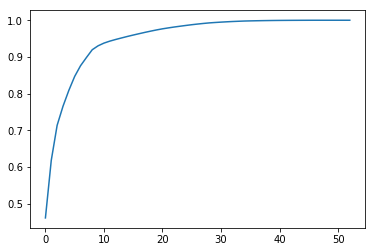

In [14]:
#PCA - find explained variance from each PC to determine an appropriate # of dimensions

pca_mod = PCA(n_components = 54)
pca_mod.fit(train_df[predictors])
explained_var = pca_mod.explained_variance_ratio_[0]
exp_vars = []

for k in range(1,54):
    explained_var += pca_mod.explained_variance_ratio_[k]
    exp_vars.append(explained_var)
    print("Variance explained by first", k, "principal components:", round(explained_var,3))
    
plt.plot(exp_vars)

#going to try 27 and 42 dimensions

In [15]:
#Project data into 42 dimensions
n = 42
pca_mod = PCA(n_components = n)
projected_train = pca_mod.fit_transform(train_df[predictors])
projected_dev = pca_mod.transform(dev_df[predictors])


# Next, evaluate a Random Forest w PCA with 500 trees. 
rf_PCA = RandomForestClassifier(n_estimators=500, oob_score=True)
scores = cross_val_score(rf_PCA, projected_train, train_df[target], cv=10)
print ("Mean R^2 = {:.3}".format(scores.mean()))

# Evaluate Random Forest w PCA on dev data. 
rf_PCA.fit(projected_train, train_df[target])
rf_PCA.score(projected_dev, dev_df[target])

Mean R^2 = 0.847


0.8486772486772487

In [15]:
#Project data into 27 dimensions
n = 27

pca_mod = PCA(n_components = n)
projected_train = pca_mod.fit_transform(train_df[predictors])
projected_dev = pca_mod.transform(dev_df[predictors])


# Next, evaluate a Random Forest w PCA with 500 trees. 
rf_PCA = RandomForestClassifier(n_estimators=500, oob_score=True)
scores = cross_val_score(rf_PCA, projected_train, train_df[target], cv=10)
print ("Mean R^2 = {:.3}".format(scores.mean()))

# Evaluate Random Forest w PCA on dev data. 
rf_PCA.fit(projected_train, train_df[target])
rf_PCA.score(projected_dev, dev_df[target])

Mean R^2 = 0.826


0.83359788359788356

In [16]:
## Use L1 Regularization (Logistic regression) to prune feature space

# set c values to test
C_vals = [0.001, .005, 0.01, 0.05, 0.1, 0.25, 0.5, 2.0]

#loop through all c values
for c in C_vals:
    # logistic regression with l1 regularization
    l1_model = LogisticRegression(C = c, penalty="l1")
    l1_model.fit(train_df[predictors], train_df[target])

    # determine which parameters are non-zero in any class
    sum_weights = np.array(l1_model.coef_[0] + l1_model.coef_[1] + l1_model.coef_[2] + l1_model.coef_[3]
                          + l1_model.coef_[4] + l1_model.coef_[5] + l1_model.coef_[6])
    pred_array = np.array(predictors)
    # new_pred is the list of non-zero parameters
    new_pred = pred_array[np.where(sum_weights != 0)]
    print("\nc-value:", c, "number parameters:", len(new_pred))
    
    rf_l1 = RandomForestClassifier(n_estimators=500, oob_score=True)
    scores = cross_val_score(rf, train_df[new_pred], train_df[target], cv=10)
    print ("Mean R^2 = {:.3}".format(scores.mean()))




c-value: 0.001 number parameters: 1
Mean R^2 = 0.536

c-value: 0.005 number parameters: 15
Mean R^2 = 0.848

c-value: 0.01 number parameters: 24
Mean R^2 = 0.856

c-value: 0.05 number parameters: 37
Mean R^2 = 0.856

c-value: 0.1 number parameters: 44
Mean R^2 = 0.855

c-value: 0.25 number parameters: 45
Mean R^2 = 0.855

c-value: 0.5 number parameters: 50
Mean R^2 = 0.856

c-value: 2.0 number parameters: 50
Mean R^2 = 0.855


In [6]:
#Same as above - just spot checking the best c-values against the dev data

# logistic regression with l1 regularization
c = 0.1
l1_model = LogisticRegression(C = c, penalty="l1")
l1_model.fit(train_df[predictors], train_df[target])

# determine which parameters are non-zero in any class
sum_weights = np.array(l1_model.coef_[0] + l1_model.coef_[1] + l1_model.coef_[2] + l1_model.coef_[3]
                      + l1_model.coef_[4] + l1_model.coef_[5] + l1_model.coef_[6])
pred_array = np.array(predictors)
# new_pred is the list of non-zero parameters
new_pred = pred_array[np.where(sum_weights != 0)]
print("\nc-value:", c, "number parameters:", len(new_pred))

rf_l1 = RandomForestClassifier(n_estimators=500, oob_score=True)
scores = cross_val_score(rf, train_df[new_pred], train_df[target], cv=10)
print ("Mean R^2 = {:.3}".format(scores.mean()))

# Evaluate Random Forest on dev data. 
rf_l1.fit(train_df[new_pred], train_df[target])
rf_l1.score(dev_df[new_pred], dev_df[target])


c-value: 0.1 number parameters: 44
Mean R^2 = 0.856


0.85582010582010581

In [17]:
# Next, optimize leaf size (100 looks best)

sample_leaf_options = [1,5,10,50,100,200,500]
for leaf_size in sample_leaf_options:
    RF = RandomForestClassifier(n_estimators = 500, oob_score = True, n_jobs = -1,max_features = "auto", min_samples_leaf = leaf_size)
    scores = cross_val_score(rf, train_df[predictors], train_df[target], cv=10)
    print ("Leaf Size", leaf_size, "Mean R^2 = {:.5}".format(scores.mean()))
    rf.fit(train_df[predictors], train_df[target])
    (rf.score(dev_df[predictors], dev_df[target]))

Leaf Size 1 Mean R^2 = 0.856
0.851851851852
Leaf Size 5 Mean R^2 = 0.854
0.853703703704
Leaf Size 10 Mean R^2 = 0.855
0.854497354497
Leaf Size 50 Mean R^2 = 0.855
0.856613756614
Leaf Size 100 Mean R^2 = 0.856
0.858201058201
Leaf Size 200 Mean R^2 = 0.855
0.856084656085
Leaf Size 500 Mean R^2 = 0.854
0.854232804233
